# Apply sMoSeq to an example dataset

This notebook applies sMoSeq to an example dataset and visualizes the outputs. The data include 21 hours of open field exploration and novel object interaction. Behavior was tracked using 3D keypoints and then analyzed with keypoint-MoSeq. 

**NOTE: This notebook fits a single model using a pre-selected stickiness hyperparameter. In practice, users should pick their own stickiness value and explore the space of possible sMoSeq outputs by fitting a batch of models with different random seeds. This is demonstrated in XXX.**

In [ ]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

import os
import glob
import tqdm
import jax
import joblib
import numpy as np
import pandas as pd
import jax.numpy as jnp
import jax.random as jr
import state_moseq as sm
import matplotlib.pyplot as plt

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


## 1. Load data

To download the example data, XXX. The dataset includes a dataframe and video (both having the same name) for each recording as shown below. The dataframes contain syllables and centroid positions at each timepoint. Only the syllable sequences are required for model fitting; the centroids and videos are used for post-hoc visualization of the learned sMoSeq states.  
```
    path/to/example_data
    ├──recording1.csv
    ├──recording1.mp4
    ├──recording2.csv
    ├──recording2.mp4
    ⋮
```

### List dataframes and inspect the first one

In [12]:
data_directory = "example_data"
fps = 120 # frame rate of the videos

df_paths = glob.glob(os.path.join(data_directory, "*.csv"))
pd.read_csv(df_paths[0]).head() # inspect an example dataframe

,syllable,x,y
0,31,160.540401,138.332376
1,31,160.223760,138.051219
2,31,159.818205,138.402919
3,31,160.342933,138.259848
4,31,160.570489,137.983635


### Load syllable sequences to dictionary

In [3]:
syllables_dict = {}
for path in tqdm.tqdm(df_paths):
    seq = pd.read_csv(path)["syllable"].to_numpy()
    syllables_dict[path] = seq

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.21it/s]


# 2. Examine timescales

The goal of sMoSeq is to identify high-level states in syllable sequences. Before fitting a model, we can assess the existence of high-level states by testing whether the sequences are non-Markovian, i.e. predictable over longer timescales than a Markov chain with equivalent transition probabilities. Predictabilitytime can be measured using mutual information (MI) between lagged timepoints from a given recording. MI will typically be high for closely-spaced timepoints and low for widely-spaced timepoints. The following code plots this decay curve for the example data and for Markov chains with equivalent lengths and transition probabilities. As a baseline, we also compute MI between syllables from different recordings.

In [14]:
num_lags = 40 # number of lags at which to compute MI
min_lag, max_lag = fps, fps * 300 # space lags between 1 and 300 seconds
lags = jnp.logspace(jnp.log10(min_lag), jnp.log10(max_lag), num_lags).astype(int)

# combine syllables into a single masked array
seqs, mask, metadata = sm.batch(syllables_dict)

# convert to jax arrays for GPU acceleration
seqs = jnp.array(seqs)
mask = jnp.array(mask)

# calculate lagged MIs (for real data, Markov chains, and shuffle baseline)
real_mis, markov_mis, shuff_mis = sm.lagged_mutual_information(seqs, mask, lags)

Computing MI: 100%|██████████| 40/40 [00:12<00:00,  3.29it/s]


### Plot lagged mutual information
The plot below shows a wide separation between the real and Markov chain-based MIs, indicating that syllable sequences are non-Markovian. It takes about ~5 seconds for the Markov chain MI to decay to chance levels, compared to ~1 minute for the real data (in the example dataset). The high-level states identified by sMoSeq should fall roughly within this range of timescales. 

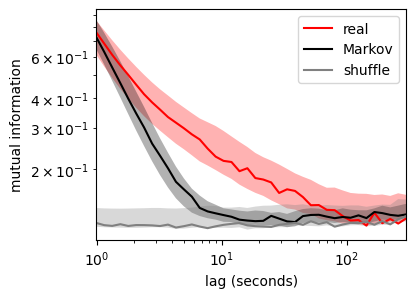

In [15]:
for mis, label, color in zip(
    [real_mis, markov_mis, shuff_mis], 
    ["real", "Markov", "shuffle"],
    ["red", "black", "gray"],
):
    mean = mis.mean(0)
    err = mis.std(0) / np.sqrt(len(mis)) * 2
    plt.plot(lags / fps, np.median(mis, axis=0), c=color, label=label)
    plt.fill_between(lags / fps, mean - err, mean + err, facecolor=color, alpha=0.3)
    
plt.xscale("log")
plt.yscale("log")
plt.xlim([lags[0] / fps, lags[-1] / fps])
plt.xlabel("lag (seconds)")
plt.ylabel("mutual information")
plt.legend(loc="upper right")
plt.gcf().set_size_inches((4,3))

# Fit sMoSeq

### Combine sequences into a single array
To allow efficient parallelization in jax, we will split each syllable sequence into segments and then combine all the data into a single masked array using the `batch` function.  This operation can be reversed using `unbatch` as demonstrated later in this tutorial. You shouldn't have to adjust `seg_length` unless indicated. 

In [4]:
seg_length = max(map(len,syllables_dict.values()))
seqs, mask, metadata = sm.batch(syllables_dict, seg_length=seg_length)

if mask.mean() < 0.75:
    print("Batching is inefficient because your recordings span a wide variety of lengths. Try manually decreasing `seg_length` until `mask.mean()` is greater than 0.75")

### Define hyperparameters
The following hyperparameters should be used with the example data. For your own dataset, you may need to change `trans_kappa`, which is a stickiness hyperparameter that controls the average duration of high-level states, and `n_states` which sets an upper limit on the number of different high-level states.

In [5]:
n_syllables = np.max(np.hstack(list(syllables_dict.values()))) + 1

hypparams = {
    "n_states": 10,
    "emission_base_sigma": 1,
    "emission_biases_sigma": 1,
    "trans_beta": 1,
    "trans_kappa": 6e5,
    "n_syllables": n_syllables,
    "emission_gd_iters": 1000,
    "emission_gd_lr": 5e-3,
    "random_seed": 0,
}

### Initialize model
The following code formats the data for fitting and randomly initializes the high-level. Because sMoSeq is probabilitistic, different initializations will lead to different final models, as explored in XXX. This variation can be explored by changing the random seed below. 

In [6]:
from state_moseq.hhmm_efficient import initialize_params, resample_states, resample_params, log_params_prob

data = {
    "syllables": jnp.array(seqs),
    "mask": jnp.array(mask)
}

seed = jr.PRNGKey(hypparams["random_seed"]) # change the random seed to explore other initializations
states = jr.randint(seed, data["syllables"].shape, 0, hypparams["n_states"])

### Fit model to data
sMoSeq uses to Gibbs sampling to iteratively refine the model parameters and high-level states. Although Gibbs sampling is typically used in the context of MCMC, our goal here is simply to get a decent point estimate. Thus we will terminate fitting once the log probability starts to plateau. 

In [7]:
parallel_fitting = False # set to False if using a CPU or if you run out of GPU memory
segment_to_save = 0 # one segment will be saved during each iteration for the purposes of visualization

log_probs = []
history = []

params = None
for _ in tqdm.trange(100, desc="Fitting model"):

    # Resample parameters and states
    seed, subseed = jr.split(seed)
    params,losses = resample_params(subseed, data, states, hypparams, params)
    states, marginal_loglik = resample_states(seed, data, params, parallel_fitting)

    # Save log probability and one segment of the current state sequence 
    log_probs.append(log_params_prob(params, hypparams).item() + marginal_loglik.item())
    history.append(np.array(states[segment_to_save][mask[segment_to_save]>0]))

    # Interrupt fitting if NaNs appear
    if np.isnan(log_probs[-1]):
        raise RuntimeError('NaNs during fitting. Try decreasing the learning rate (`hypparams["emission_gd_lr"]`)')

Fitting model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [20:40<00:00, 12.40s/it]


### Check gradient descent
Gradient descent is used to update the parameters during each iteration of Gibbs sampling. It may be useful to check whether this step converges for new datasets. The plot below shows losses from the most recent Gibbs iteration. If the loss fails to plataeu, try increasing the number of iterations (`hypparams["emission_gd_iters"]`). If the loss is unstable (i.e. shows increases), try decreasing the learning rate (`hypparams["emission_gd_lr"]`).

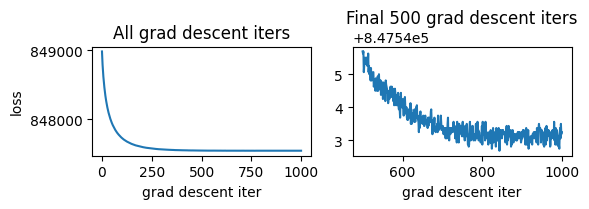

In [8]:
fig,axs = plt.subplots(1,2)
plot_from_iter = 500
axs[0].plot(np.arange(len(losses)), losses)
axs[0].set_title("All grad descent iters")
axs[1].plot(np.arange(plot_from_iter,len(losses)), losses[plot_from_iter:])
axs[1].set_title(f"Final {len(losses)-plot_from_iter} grad descent iters")
axs[0].set_ylabel("loss")
axs[0].set_xlabel("grad descent iter")
axs[1].set_xlabel("grad descent iter")
fig.set_size_inches((6,2.2)) 
plt.tight_layout()

### Check overall convergence
Confirm that the log probrobality reaches a plateau. If not, try running Gibbs sampling for more iterations.

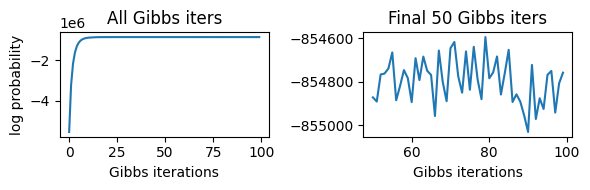

In [9]:
fig,axs = plt.subplots(1,2)
plot_from_iter = 50
axs[0].plot(np.arange(len(log_probs)), log_probs)
axs[0].set_title("All Gibbs iters")
axs[1].plot(np.arange(plot_from_iter,len(log_probs)), log_probs[plot_from_iter:])
axs[1].set_title(f"Final {len(log_probs)-plot_from_iter} Gibbs iters")
axs[0].set_ylabel('log probability')
axs[0].set_xlabel('Gibbs iterations')
axs[1].set_xlabel('Gibbs iterations')
fig.set_size_inches((6,2)) 
plt.tight_layout()

### Visualize state history
The following heatmap shows the evolution of high-level states across fitting iterations (only an example 10-minute interval is shown).

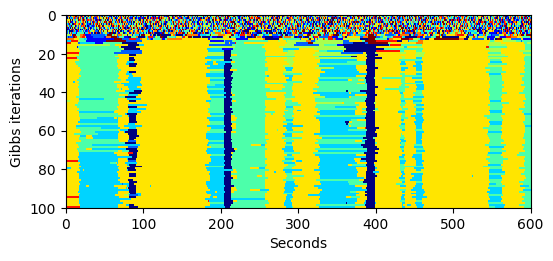

In [16]:
start, end = 0, 600 * fps # defines the interval to be plotted

plt.imshow(
    np.array(history)[:,start : end], 
    cmap=plt.cm.jet, 
    aspect='auto', 
    interpolation='none', 
    extent=[start/fps, end/fps, len(history), 0]
)
plt.ylabel("Gibbs iterations")
plt.xlabel("seconds")
plt.gcf().set_size_inches((6,2.5))

### Unbatch state sequences and save to disk
The following code uses `unbatch` (inverse of the `batch` function used above) to generate a dictionary with the inferred high-level state sequence for each recording. 

In [ ]:
states_dict = sm.unbatch(np.array(states), *metadata)

We will save the modeling results to two files: one containing the state sequences and one containing the hyperparameters, parameters, and log likelihoods from fitting. Both files are pickled using joblib. 

In [ ]:
prefix = "example_data" # change as needed
joblib.dump(states_dict, f"{prefix}-state_sequences.p")

additional_info = {
    "params": jax.device_get(params), # convert to numpy arrays
    "hypparams": hypparams,
    "log_probs": log_probs,
}
joblib.dump(additional_info, f"{prefix}-additional_info.p")

['states_dict.p']

### Plot duration distribution
The histogram below shows the distribution of time intervals between consecutive state transitions

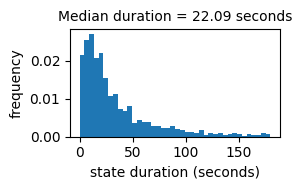

In [39]:
durations = sm.get_durations(states_dict)

plt.hist(durations / fps, bins=40, range=(0, 180), density=True);
plt.title(f"Median duration = {round(np.median(durations / fps),2)} seconds", size=10)
plt.xlabel("state duration (seconds)")
plt.ylabel("frequency")
plt.gcf().set_size_inches((3,2))
plt.tight_layout()

### Plot frequency distribution
Although the model was fit using a fixed number of high-level states (determined by `hypparams["n_states"]`), it may be possible to describe behavior using a small number. The bar plot below shows the total proportion of frames assigned to each state. States for which this proportion is very small (less than 1-2%) should be excluded. 

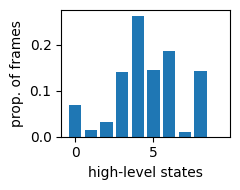

In [18]:
state_counts = np.bincount(np.hstack(list(states_dict.values())))
state_proportions = state_counts / state_counts.sum()
plt.bar(np.arange(len(state_proportions)), state_proportions)
plt.xlabel("high-level states")
plt.ylabel("prop. of frames")
plt.gcf().set_size_inches((2.5,2))
plt.tight_layout()

# Visualize high-level states
The content of the high-level states can be visualized using "grid movies". Each movie shows a grid of examples of a particular state. For each example, the video starts at the moment when the animal enters the state, and then goes dark when the animal exits the state. The code below, which generates a grid movie for each state, may take several minutes to execute.

In [2]:
video_paths = {}
centroids = {}
for path in tqdm.tqdm(df_paths):
    centroids[path] = pd.read_csv(path)[["x","y"]].to_numpy()
    video_paths[path] = path.replace(".csv", ".mp4")

sm.generate_grid_movies(states_dict, video_paths, centroids);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.44it/s]
